In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
from nltk import pos_tag, word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [3]:
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary  
from gensim import corpora, models     
from gensim.test.utils import datapath  
from gensim.models import LdaMulticore 

In [5]:
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.decomposition import PCA
from pprint import pprint

from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn import preprocessing, model_selection, metrics, feature_selection


import datetime, warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [6]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot, plot, download_plotlyjs
init_notebook_mode(connected=True)

In [11]:
file_path = r"C:\Users\shoba\OneDrive\Desktop\data.csv"

In [12]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1", dtype= {'CustomerID': str})  
## CustomerID  is float (1532.0)-> str while reading the dataset will remove .0 at end
## if convert it to string after reading 
## df['CustomerID'] = df['CustomerID'].astype('str')
## the .0 will be treated as character and remain in the 'CustomerID' Field

# take long time!
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

Cleaning Data

In [14]:
nullTable = pd.DataFrame(df.dtypes).T.rename(index={0: "types"})

nullTable = pd.concat([
    nullTable,
    pd.DataFrame(df.isnull().sum()).T.rename(index={0: "count"}),
    pd.DataFrame((df.isnull().sum() / df.shape[0]) * 100).T.rename(index={0: "%"})
])

nullTable

InvoiceNo StockCode Description Quantity     InvoiceDate UnitPrice  \
types    object    object      object    int64  datetime64[ns]   float64   
count         0         0        1454        0               0         0   
%           0.0       0.0    0.268311      0.0             0.0       0.0   

      CustomerID Country  
types     object  object  
count     135080       0  
%      24.926694     0.0

Around 25% of Customers Ids are null ... can't deal with such prob, so we drop them

In [15]:
df.dropna(axis= 0, subset=['CustomerID'], inplace=True)

In [16]:
pd.DataFrame(df.isnull().sum()).T

InvoiceNo  StockCode  Description  Quantity  InvoiceDate  UnitPrice  \
0          0          0            0         0            0          0   

   CustomerID  Country  
0           0        0

Great, Now data is cleaned of null values, Now removing duplicates



In [17]:
print("There Exist {:,} duplications in our data,".format(df.duplicated().sum()))

There Exist 5,225 duplications in our data,


In [18]:
df.drop_duplicates(inplace=True)

Our data shape after such cleaning processes

In [19]:
df.shape

(401604, 8)

In [20]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

Exploring Data

► InvoiceNo : Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

► StockCode : Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product
.
► Description : Product (item) name. Nomina
l.
► Quantity : The quantities of each product (item) per transaction. Numer
ic.
► InvoiceDate : Invice Date and time. Numeric, the day and time when each transaction was genera
ted.
► UnitPrice : Unit price. Numeric, Product price per unit in ster
ling.
► CustomerID : Customer number. Nominal, a 5-digit integral number uniquely assigned to each cus
tomer.
► Country : Country name. Nominal, the name of the country where each customer resides.

i) Country

In [22]:
print( "We have {} countires trading all over the world ".format(df.Country.nunique()))

We have 37 countires trading all over the world 


In [23]:
countries = df.Country.value_counts()
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names', z = countries,
            text = countries.index, colorbar = {'title':'Orders'},
            colorscale= 'Reds',
            reversescale = False
           )
layout = dict(title='Geographic View',
                geo = dict(showframe = True, projection=dict(type = 'winkel tripel'))
             )
gmap = go.Figure(data = [data], layout = layout)
py.iplot(gmap)

Apparently most of our sales from United Kingdom



In [24]:
data = [
    go.Bar(
        y = countries.index[:7],
        x = countries.values[:7],
        orientation='h',
        marker={
            'color':countries.values,
            'colorscale': 'Portland'
            }
        )
     ]

py.iplot(data, filename='basic-bar')

In [25]:
pd.DataFrame([{
    'Customers': df.CustomerID.nunique(),
    'Products': df.StockCode.nunique(),
    'Transactions': df.InvoiceNo.nunique()
            }
]).rename(index = {0:"Num"})

Customers  Products  Transactions
Num       4372      3684         22190

In [26]:
customers = df.CustomerID.value_counts().sort_values(ascending=False)
print("99% of Users  Make {:.0f} Transactions, While Our Favourite Client Visits us {} times".
      format(np.round(customers.quantile(0.99)), customers.max()))

99% of Users  Make 658 Transactions, While Our Favourite Client Visits us 7812 times


Check How many products in each transaction


In [27]:
temp = df.groupby(by=['CustomerID','InvoiceNo'])['InvoiceDate'].count().reset_index()
temp = temp.rename(columns={'InvoiceDate':'Num. Products'})
temp.head(10)

CustomerID InvoiceNo  Num. Products
0      12346    541431              1
1      12346   C541433              1
2      12347    537626             31
3      12347    542237             29
4      12347    549222             24
5      12347    556201             18
6      12347    562032             22
7      12347    573511             47
8      12347    581180             11
9      12348    539318             17

ii) Analysis on cancelation processes


'C' character followed by the Invoice no. means that such Transcation is cancelled.

In [28]:
temp['cancels'] = temp.InvoiceNo.apply(lambda x: int(x[0] == 'C'))

temp.sort_values(by='CustomerID').head()



CustomerID InvoiceNo  Num. Products  cancels
0      12346    541431              1        0
1      12346   C541433              1        1
2      12347    537626             31        0
3      12347    542237             29        0
4      12347    549222             24        0

In [29]:
print("There exist {:.2f}% Cancelations".format(temp.cancels.sum() / temp.shape[0] * 100))

There exist 16.47% Cancelations


That's not a small percent for cancelled transactions ... lets see most products being Cancelled



In [30]:
dfc = df.copy()
dfc['cancels'] = dfc.InvoiceNo.apply(lambda x: int(x[0] == 'C'))

dfc.groupby(by=['StockCode', 'Description'])['cancels'].count().sort_values(ascending=False).reset_index().head(10)


StockCode                         Description  cancels
0    85123A  WHITE HANGING HEART T-LIGHT HOLDER     2058
1     22423            REGENCY CAKESTAND 3 TIER     1894
2    85099B             JUMBO BAG RED RETROSPOT     1659
3     47566                       PARTY BUNTING     1409
4     84879       ASSORTED COLOUR BIRD ORNAMENT     1405
5     20725             LUNCH BAG RED RETROSPOT     1345
6     22720   SET OF 3 CAKE TINS PANTRY DESIGN      1224
7      POST                             POSTAGE     1196
8     20727             LUNCH BAG  BLACK SKULL.     1099
9     21212     PACK OF 72 RETROSPOT CAKE CASES     1062

Some orders were Completely canceled ... which are just duplications of their orders except that
Time is different, StockCode begins with 'C', and Quantity is assigned a negative value

Other Orders were canceled without their real orders observations
Which means that such transaction made before December 2010 [ where the data begins ]



warning : take long time

In [32]:
df_n = df.copy()

df_n['QuantityCancelled'] = 0
removeEntry = []; doubtEntry = []


for indexA, col in df.iterrows():
    if (col['Quantity'] > 0) or (col['Description'] == 'Discount'): continue
    temp = df.loc[(df['CustomerID'] == col['CustomerID']) &
                  (df['StockCode']  == col['StockCode'])  &
                  (df['InvoiceDate'] < col['InvoiceDate'])&
                  (df['Quantity']    >      0)].copy()
    
    ## Order Before Dec. 2010 and Cancelled after Dec 2010
    if(temp.shape[0]   == 0):
        doubtEntry.append(indexA)
    ## The real order exist
    elif(temp.shape[0] == 1):
        df_n.loc[temp.index[0], 'QuantityCancelled'] = -col['Quantity']
        removeEntry.append(indexA)
    
    ## Many real orders for such cancellation, will modify only the same Quantity, and remove the entry
    else:
        temp.sort_index(axis=0, ascending=False, inplace=True)
        for i, v in temp.iterrows():
            if v['Quantity'] < -col['Quantity'] : continue  ## cant cancel more than he bought
            df_n.loc[i, 'QuantityCancelled'] = -col['Quantity']
            removeEntry.append(indexA)
            break

In [33]:
print('To be removed: {} with percentage {:.1f}%'.format(len(removeEntry), len(removeEntry) / df_n.shape[0] *100 ))
print('Waiting: {} with percentage {:.1f}%'.format(len(doubtEntry), len(doubtEntry) / df_n.shape[0] *100 ))

To be removed: 7521 with percentage 1.9%
Waiting: 1226 with percentage 0.3%


Due to the low Percentage of the Doubtful entries, we can remove them without being highly affected

In [34]:
df_n.drop(removeEntry, axis=0, inplace=True)
df_n.drop(doubtEntry, axis=0, inplace=True)

In [35]:
## remaining Cancelled entries ... with unknown real records ... and not discounts
temp = df_n.loc[ (df['Quantity'] < 0) & (df['StockCode'] != 'D') ]
#print("Rest of bad entries : {}".format(temp.shape[0]))

Total cash of the transaction

In [36]:
df_n['ttlCashe'] = df_n['UnitPrice'] * (df_n['Quantity'] - df_n['QuantityCancelled'])
df_n.sort_values(by='CustomerID').head()

InvoiceNo StockCode                        Description  Quantity  \
61619     541431     23166     MEDIUM CERAMIC TOP STORAGE JAR     74215   
148288    549222     22375  AIRLINE BAG VINTAGE JET SET BROWN         4   
428971    573511     22698     PINK REGENCY TEACUP AND SAUCER        12   
428970    573511    47559B                TEA TIME OVEN GLOVE        10   
428969    573511    47567B             TEA TIME KITCHEN APRON         6   

               InvoiceDate  UnitPrice CustomerID         Country  \
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom   
148288 2011-04-07 10:43:00       4.25      12347         Iceland   
428971 2011-10-31 12:25:00       2.95      12347         Iceland   
428970 2011-10-31 12:25:00       1.25      12347         Iceland   
428969 2011-10-31 12:25:00       5.95      12347         Iceland   

        QuantityCancelled  ttlCashe  
61619               74215       0.0  
148288                  0      17.0  
428971                  0      35.4  
428970                  0      12.5  
428969                  0      35.7

In [37]:
basket= df_n.groupby(by=['CustomerID','InvoiceNo'])['ttlCashe'].sum().reset_index()
basket= basket[basket['ttlCashe'] > 0]
basket.sort_values(by='CustomerID').head()

CustomerID InvoiceNo  ttlCashe
1      12347    537626    711.79
2      12347    542237    475.39
3      12347    549222    636.25
4      12347    556201    382.52
5      12347    562032    584.91

In [38]:
basket.ttlCashe.describe()

count    18398.000000
mean       456.338095
std        924.771216
min          0.380000
25%        155.355000
50%        299.390000
75%        462.957500
max      30757.000000
Name: ttlCashe, dtype: float64

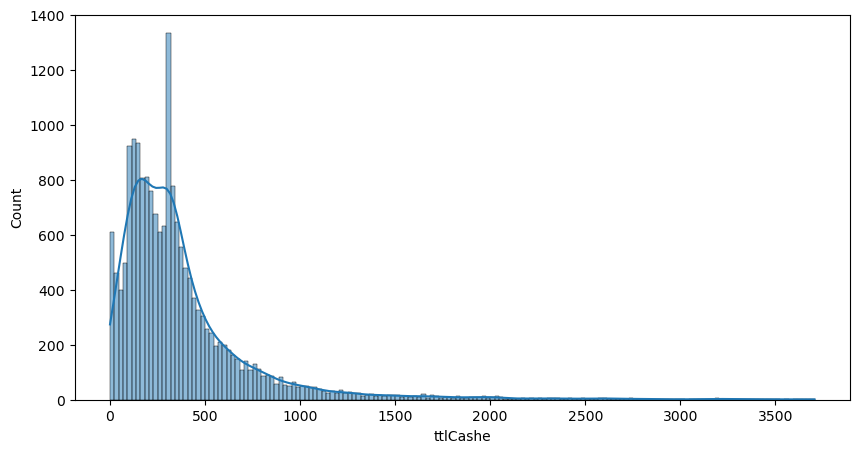

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(10, 5))

sns.histplot(basket[basket["ttlCashe"] < basket["ttlCashe"].quantile(0.99)]["ttlCashe"], kde=True)

sns.axes_style()
plt.show()

In [40]:
temp = basket.copy()
temp['PriceGroups'] = pd.cut(temp['ttlCashe'], [0,50,155,300,465,1000, 10_000,31_000],
                             labels=['< 50', '50<.<155', '155<.<300', '300<.<465', '465<.<1K', '1K<10K','+10K',])

pieChart = go.Pie( labels = temp['PriceGroups'].values, values = temp['ttlCashe'].values, hole = .4 ) layout = go.Layout( dict( title="Sales Ranges" ) ) data = [pieChart] py.iplot(dict(data=data, layout = layout),filename='Pie-chart')

Which indicates majority of our Sales ranges around 1K - 10K £ ,

Clustering

Product Categories

Create Categories for produts according to their description, using Bag-Of-Words/ TF-IDF and Latent diricliet allocation (LDA) Model of clustering

helper methods for getting root of keywords

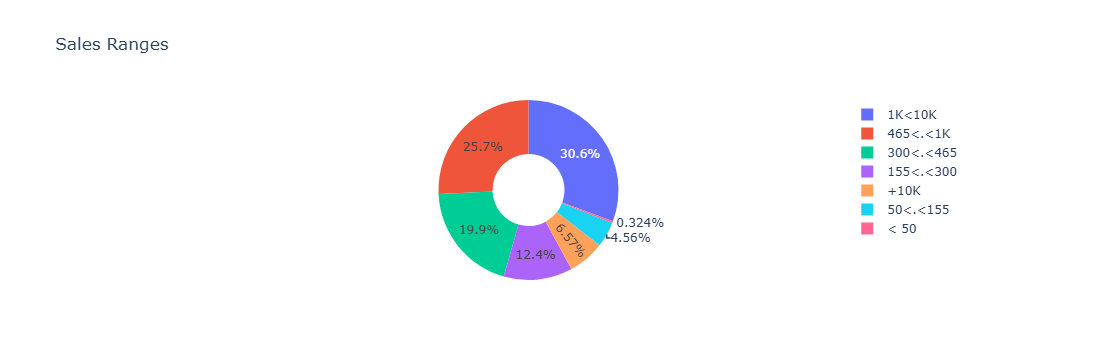

In [41]:
pieChart = go.Pie(
                labels = temp['PriceGroups'].values,
                values = temp['ttlCashe'].values,
                hole = .4
                )
layout = go.Layout(
                dict(
                    title="Sales Ranges"
                    )
                )
data = [pieChart]
py.iplot(dict(data=data, layout = layout),filename='Pie-chart')

Which indicates majority of our Sales ranges around 1K - 10K £ ,

Clustering
Product Categories
Create Categories for produts according to their description,
using Bag-Of-Words/ TF-IDF and Latent diricliet allocation (LDA) Model of clustering

helper methods for getting root of keywords

stemmer = SnowballStemmer("english")
# Tokenize and lemmatize
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))


def preprocess(text):
    result=[]
    for token in simple_preprocess(text) :
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [43]:
products = df_n['Description'].unique()
productsTkns = pd.Series(products).map(preprocess)

Dictionary is a key with word id and its value is the frequency of such word all over documents

In [44]:
dictionary = Dictionary(productsTkns)

remove extreme tokens (bought in less than 15 product, bought in more than 10% of all products )

In [46]:
print("The remaining keywords to get into the model {} words".format(len(dictionary)))

The remaining keywords to get into the model 1559 words


Bag of word technique, count frequency of word in each product



In [47]:
bow_corpus = [dictionary.doc2bow(product) for product in productsTkns]

TF-IDF which assign score for each word in each product according to its importance

In [48]:
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

Clustering Products using LDA

In [49]:
lda_model_tfidf = LdaMulticore(tfidf_corpus,
                                  id2word=dictionary,
                                  passes=50,
                                  num_topics=6)

Count number of products in each cluster

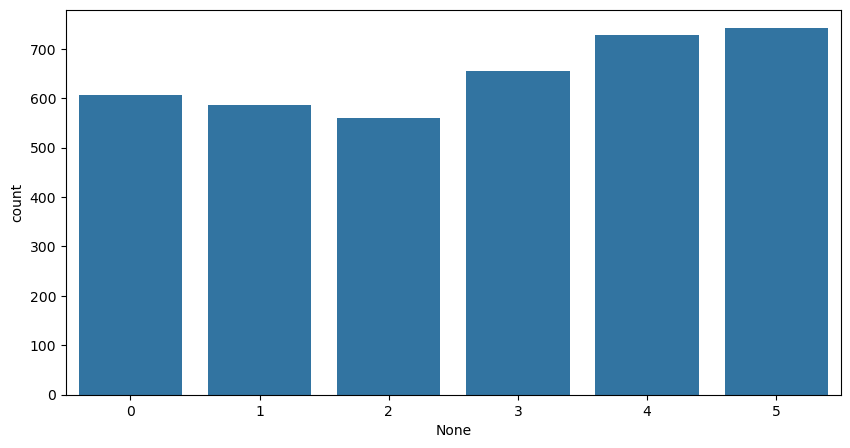

In [52]:
clusters = []
for doc_num in range(len(products)):
    winCat = sorted(lda_model_tfidf[bow_corpus[doc_num]], key=lambda tup: -1 * tup[1])[0][0]
    clusters.append(winCat)

plt.subplots(figsize=(10, 5))
sns.countplot(x=pd.Series(clusters)) 
plt.show()

WordCloud

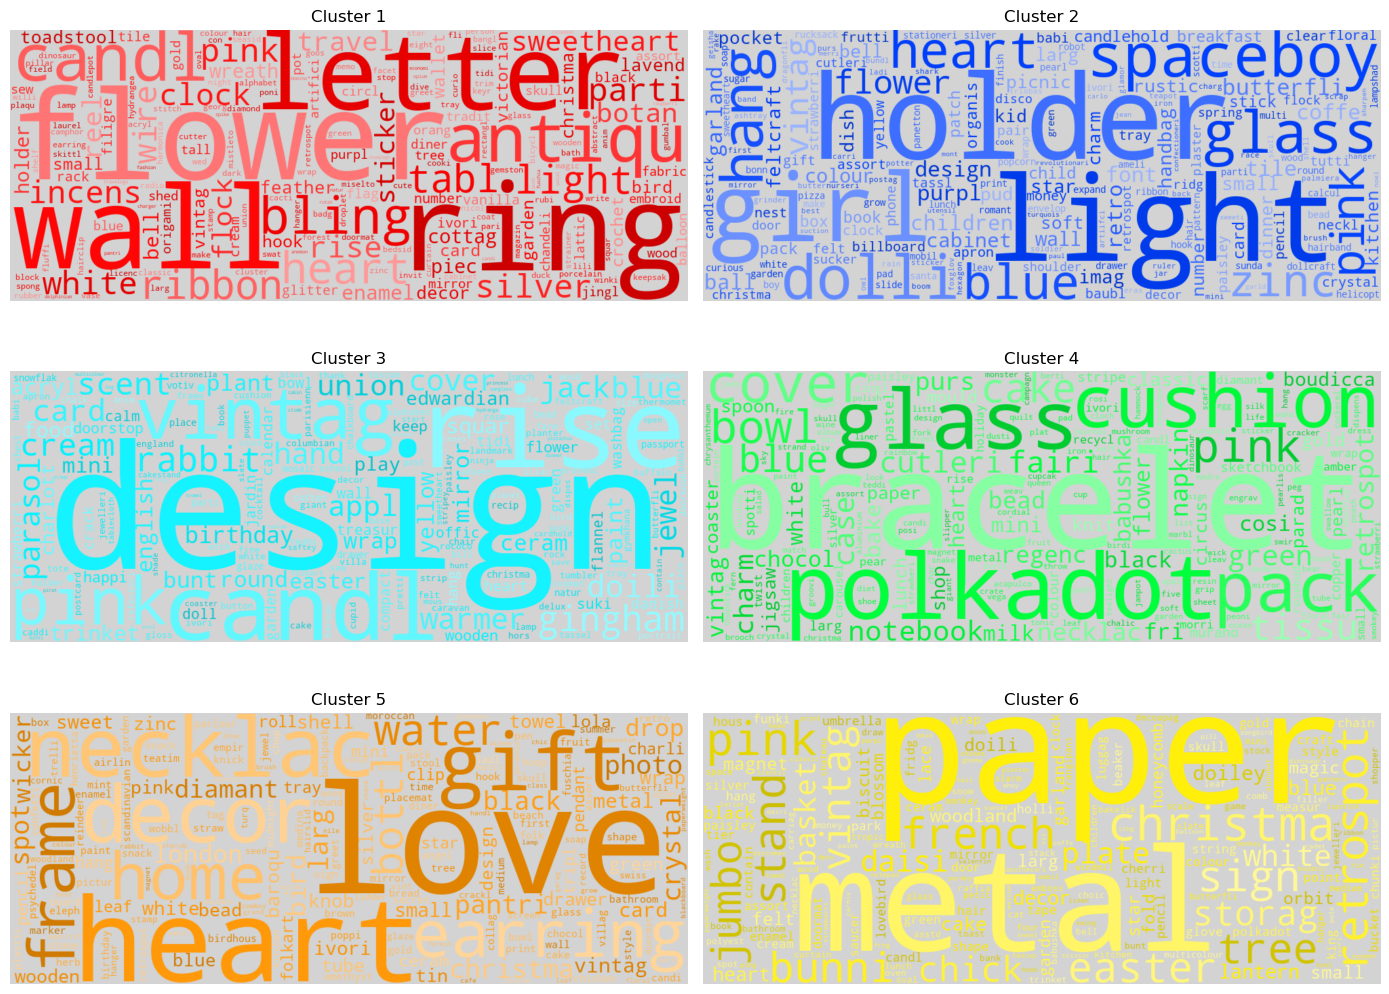

In [61]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random

# Custom color function with dynamically assigned tone
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None, tone=0):
    h = int(360.0 * tone / 255.0)  # Convert tone to hue
    s = 100  # Saturation at 100%
    l = random.randint(40, 80)  # Lightness between 40-80% for good contrast
    return f"hsl({h}, {s}%, {l}%)"

# Function to generate and display the word cloud
def make_wordCloud(topic_num, tone, fig):
    ax1 = fig.add_subplot(4, 2, topic_num + 1)  # Adjust subplot layout as needed

    wordcloud = WordCloud(
        width=1000, 
        height=400,
        background_color="lightgrey",
        color_func=lambda *args, **kwargs: random_color_func(*args, **kwargs, tone=tone)
    )

    # Fit the word cloud with topic words
    wordcloud.fit_words(dict(lda_model_tfidf.show_topic(topic_num, 200)))

    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis("off")
    ax1.set_title(f"Cluster {topic_num + 1}")

# Define colors for each topic
color_tones = [0, 160, 130, 95, 280, 40, 330, 110, 25]

# Initialize figure
fig = plt.figure(figsize=(14, 14))

# Generate word clouds for all topics
for topic_num in range(lda_model_tfidf.num_topics):
    make_wordCloud(topic_num, color_tones[topic_num], fig)

plt.tight_layout()
plt.show()

Some Observations about the Clusters

We assign tfIDF scores of each term of each document in a ***matrix*** for clustering purposes

In [63]:
## take the only 300 words filtered from products by dictionary
dict_prds =[]
for index, word in dictionary.iteritems():
    dict_prds.append(word)

initialize dictionary with 1 if such word exist in such product, or 0 otherwise

In [64]:
X = pd.DataFrame()
for word in dict_prds:
    X.loc[:, word] = list(map( lambda x: int(word.upper() in x) , products))

assign the tf-Idf scores for each word in product
rather than the binary-representation done above

In [65]:
for i, tf in enumerate(tfidf_corpus):
    for j, score in enumerate(tf):
        word = dictionary.get(score[0])
        X.loc[i,word] = score[1]

In [66]:
X.head()

hang     heart    holder     light     white   lantern     metal  \
0  0.496648  0.363789  0.473181  0.442801  0.448359  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.473390  0.719441  0.508238   
2  1.000000  0.222864  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.214945  0.000000  0.000000  0.264912  0.000000  0.000000   

       coat     cream     cupid  ...  tradtion  blueberri  fondant  chrome  \
0  0.000000  0.000000  0.000000  ...       0.0        0.0      0.0     0.0   
1  0.000000  0.000000  0.000000  ...       0.0        0.0      0.0     0.0   
2  0.515743  0.361245  0.597548  ...       0.0        0.0      0.0     0.0   
3  0.000000  0.000000  0.000000  ...       0.0        0.0      0.0     0.0   
4  0.000000  0.000000  0.000000  ...       0.0        0.0      0.0     0.0   

   crome  panetton  czech  punctur  countri  perfect  
0    0.0       0.0    0.0      0.0      0.0      0.0  
1    0.0       0.0    0.0      0.0      0.0      0.0  
2    0.0       0.0    0.0      0.0      0.0      0.0  
3    0.0       0.0    0.0      0.0      0.0      0.0  
4    0.0       0.0    0.0      0.0      0.0      0.0  

[5 rows x 1559 columns]

In [67]:
X.shape

(3878, 1559)

Adding the Price feature, which can increase the Accuracy of clustering
7 Columns with categorical data, for which each product range of price falls



In [68]:
priceCat = [0,1,2,3,4,5,10]
catCols = []

for i, p in enumerate(priceCat):
    if i == len(priceCat) - 1:
        col = "+{}".format(priceCat[i])
    else:
        col = "{}<.<{}".format(priceCat[i], priceCat[i+1])
    catCols.append(col)
    X.loc[:, col] = 0
    
for i, prod in enumerate(products):
    priceAvg = df_n[df_n['Description'] == prod]['UnitPrice'].mean()
    k = 0
    while priceAvg > priceCat[k]:
        k += 1
        if k == len(priceCat): break
    
    X.loc[i, catCols[k-1]] = 1

Count Products in each Price Category

In [69]:
for cat in catCols:
    print(f"{cat} \t\t {X.loc[:, cat].sum()}")

0<.<1 		 964
1<.<2 		 1009
2<.<3 		 673
3<.<4 		 296
4<.<5 		 310
5<.<10 		 470
+10 		 156


Clustering Products using KMeans


In [71]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs  # Example dataset

# Example: Create synthetic data (if you don't have mat defined)
X, _ = make_blobs(n_samples=300, n_features=2, centers=5, random_state=42)

mat = X  # Ensure 'mat' is assigned before using it

for n_cluster in range(3, 10):
    KM = KMeans(n_clusters=n_cluster, random_state=42)
    clustersKM = KM.fit_predict(mat)
    
    silh_score = silhouette_score(mat, clustersKM)
    print("For {} clusters, Score = {:.4f}".format(n_cluster, silh_score))

For 3 clusters, Score = 0.7109
For 4 clusters, Score = 0.7323
For 5 clusters, Score = 0.6530
For 6 clusters, Score = 0.5825
For 7 clusters, Score = 0.5597
For 8 clusters, Score = 0.4889
For 9 clusters, Score = 0.4934


let's choose 6 clusters as it's from LDA Model

For 6 clusters, Score = 0.5825


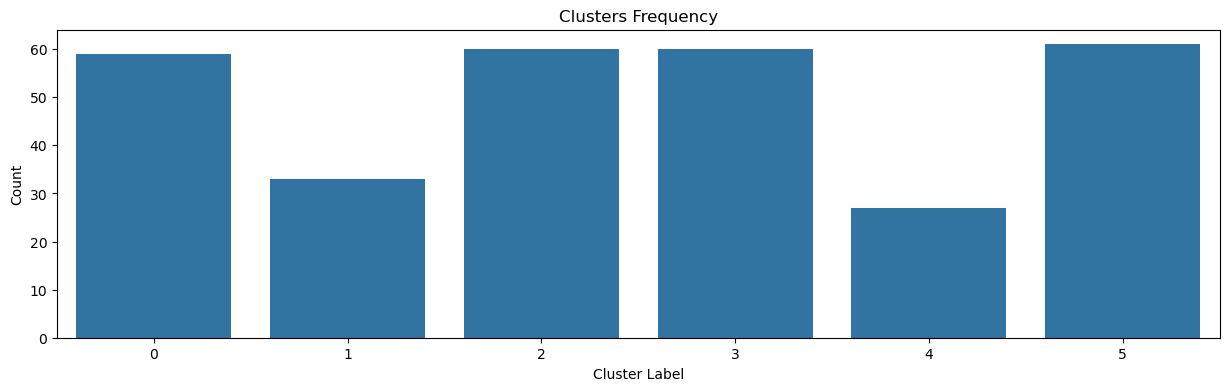

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming 'mat' is already defined and contains the feature matrix

n_cluster = 6
silh_score = -1

# Preventing infinite loop by limiting iterations
max_iterations = 10
iteration = 0

while silh_score < 0.22 and iteration < max_iterations:
    KM = KMeans(n_clusters=n_cluster, random_state=42)
    clustersKM = KM.fit_predict(mat)
    
    silh_score = silhouette_score(mat, clustersKM)
    iteration += 1  # Track the number of iterations

print(f"For {n_cluster} clusters, Score = {silh_score:.4f}")

# Plot the cluster frequency
fig = plt.figure(figsize=(15, 4))
sns.countplot(x=pd.Series(clustersKM))  # Explicitly specify 'x' for seaborn
plt.title("Clusters Frequency")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.show()


PCA

In [81]:
from sklearn.decomposition import PCA

mat = X  # No need to use as_matrix()
pca = PCA()
pca_components = pca.fit_transform(mat)

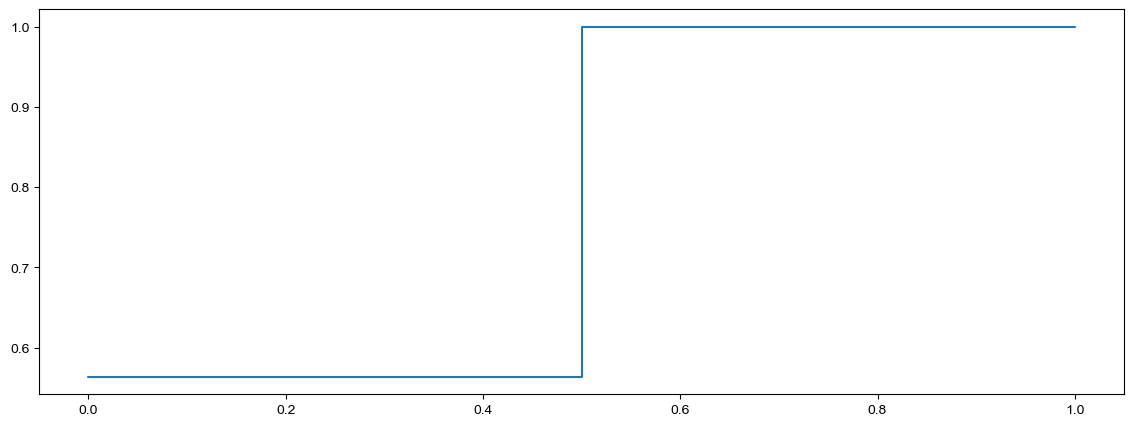

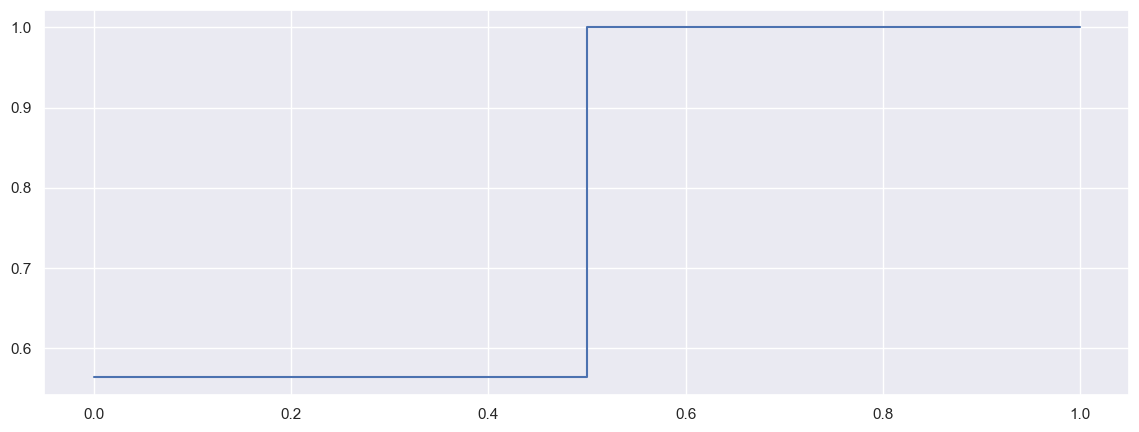

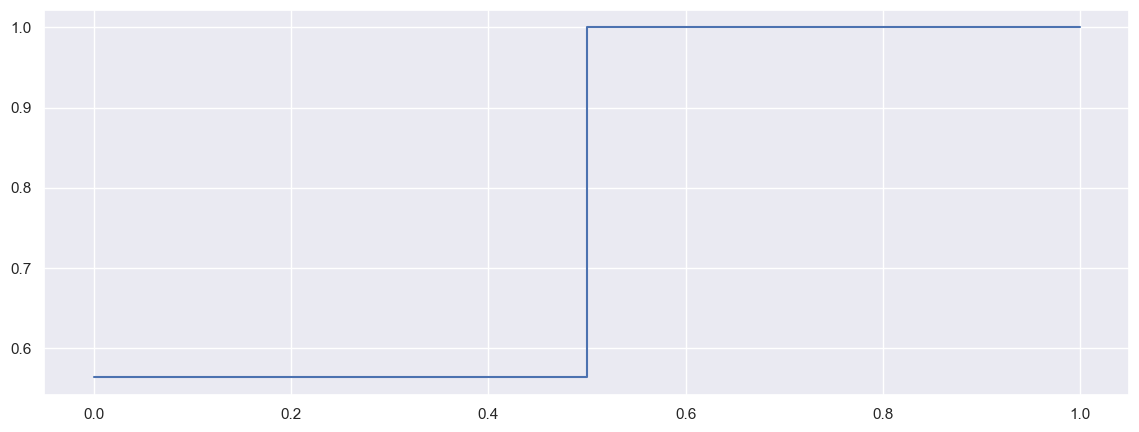

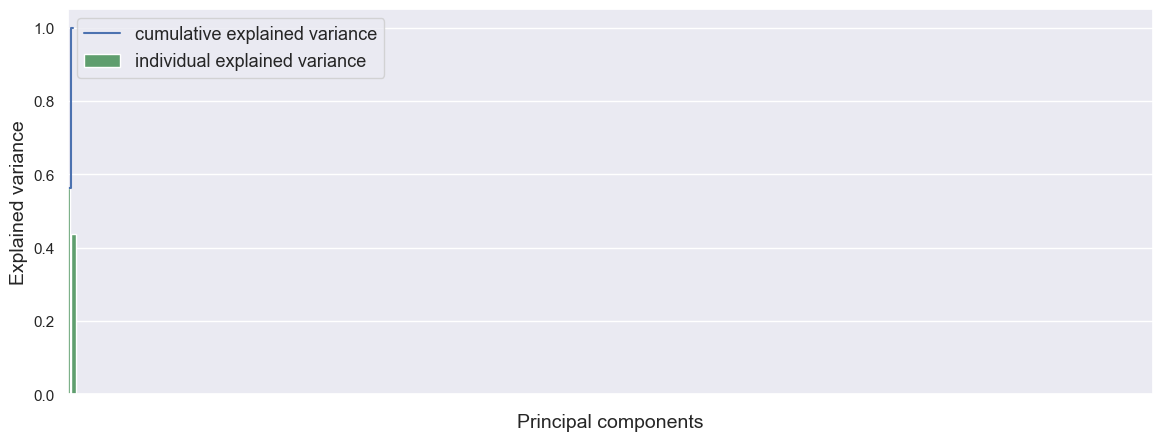

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)

# Plot cumulative explained variance
plt.step(range(mat.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')

# Fix: Use explicit x and y parameters in barplot
sns.barplot(x=np.arange(1, mat.shape[1]+1), y=pca.explained_variance_ratio_,
            color='g', label='individual explained variance')

plt.xlim(0, 200)
plt.ylabel('Explained variance', fontsize=14)
plt.xlabel('Principal components', fontsize=14)
plt.legend(loc='upper left', fontsize=13)

# Fix: Ensure tick labels are properly formatted
ax.set_xticklabels([s.get_text() if int(s.get_text()) % 5 == 0 else '' for s in ax.get_xticklabels()])

plt.show()


Some Visualizations


In [94]:
pcdf = pd.DataFrame(pca_components)
pcdf['clusters'] = pd.Series(clusters)

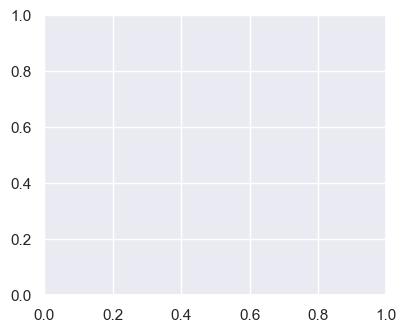

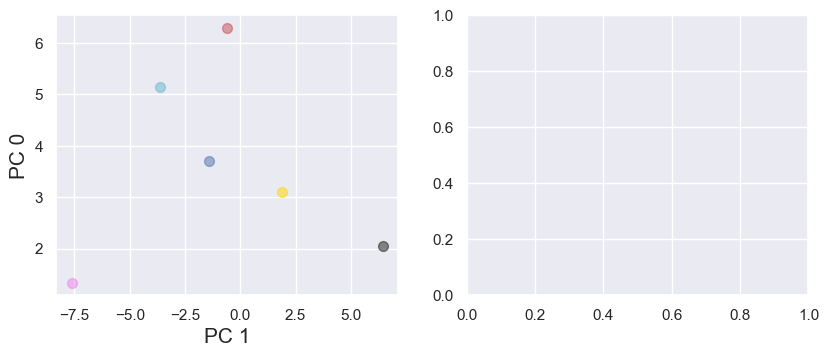

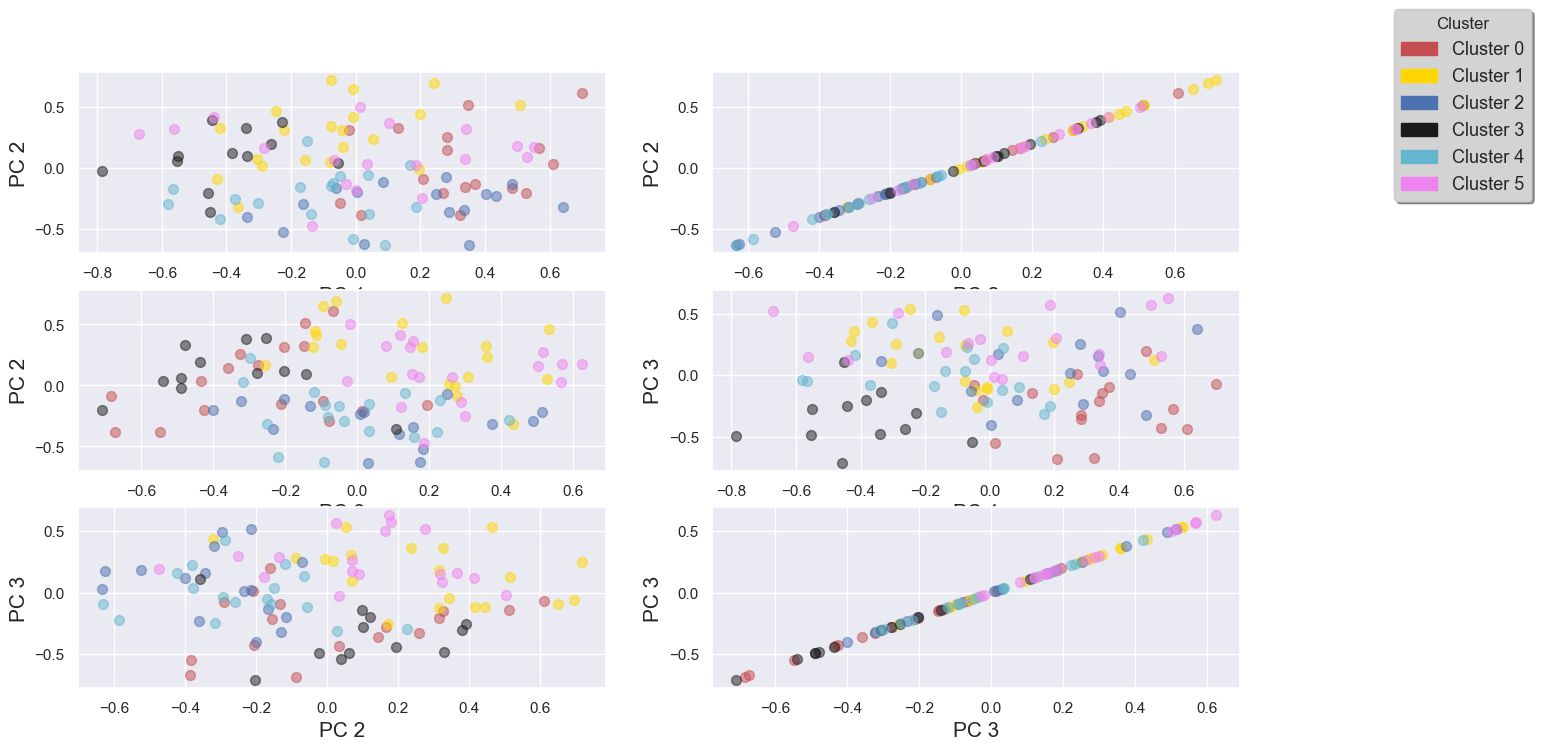

In [96]:
# Dummy Data: Simulating PCA Components
np.random.seed(42)
data = np.random.rand(100, 6)  # 100 samples, 6 features
pca = PCA(n_components=6)
pca_components = pca.fit_transform(data)

# Clustering for visualization
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(pca_components)

# Creating DataFrame
pcdf = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(pca_components.shape[1])])
pcdf['clusters'] = pd.Series(clusters)

# Define Colors for Clusters
colors = ['r', 'gold', 'b', 'k', 'c', 'violet']

# Function to plot PCA components
def make_pca_plot(pcomps, a, b, inc, w=2, h=3):
    ax = fig.add_subplot(h, w, inc)  # Fix subplot layout
    for cluster, color in zip(range(6), colors):  # Using range(6) to match cluster labels
        indx = pcomps['clusters'] == cluster
        ax.scatter(pcomps.loc[indx, f'PC{a}'], 
                   pcomps.loc[indx, f'PC{b}'], 
                   c=color, s=50, alpha=0.5)
    
    ax.set_xlabel(f'PC {a}', fontsize=15)
    ax.set_ylabel(f'PC {b}', fontsize=15)

# Create Figure
fig = plt.figure(figsize=(15, 8))

# Loop through 6 plots (2x3 grid)
for i in range(2):  # 2 rows
    for j in range(3):  # 3 columns
        make_pca_plot(pcdf, j+1, i+2, j+1 + i*3)  # Adjusted indexing

# Create legend
LABEL_COLOR_MAP = {0: 'r', 1: 'gold', 2: 'b', 3: 'k', 4: 'c', 5: 'violet'}
comp_handler = [mpatches.Patch(color=LABEL_COLOR_MAP[i], label=f'Cluster {i}') for i in range(6)]

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor='lightgrey',
           shadow=True, frameon=True, framealpha=1,
           fontsize=13, bbox_transform=plt.gcf().transFigure)

plt.show()

To be noticed, that some clusters can be separated at various PC plots

Customer Categorization

After acquiring product cluster analysis, we add such information in our dataframe, adding cat_NN Feature which indicate category of each product, according to KMeans clustering

In [97]:
clusterAssign = dict()

for p, c in zip(products, clustersKM):
    clusterAssign[p] = c

In [98]:
df_n['cat_KM'] = df_n['Description'].map(clusterAssign)

In [99]:
df_n.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  \
0 2010-12-01 08:26:00       2.55      17850  United Kingdom   
1 2010-12-01 08:26:00       3.39      17850  United Kingdom   
2 2010-12-01 08:26:00       2.75      17850  United Kingdom   
3 2010-12-01 08:26:00       3.39      17850  United Kingdom   
4 2010-12-01 08:26:00       3.39      17850  United Kingdom   

   QuantityCancelled  ttlCashe  cat_KM  
0                  0     15.30     3.0  
1                  0     20.34     5.0  
2                  0     22.00     3.0  
3                  0     20.34     0.0  
4                  0     20.34     3.0

Adding 6 Features for the 6 product clusters, containing the amount of cashe payed through each invoice

In [100]:
for i in range(6):
    cat  = 'category_{}'.format(i)
    temp = df_n[df_n['cat_KM'] == i]
    cashe = temp['UnitPrice'] * (temp['Quantity'] - temp['QuantityCancelled'])
    cashe = cashe.apply(lambda x: x if x > 0 else 0)
    df_n.loc[:, cat] = cashe
    df_n[cat].fillna(0, inplace = True)

In [101]:
df_n[['InvoiceNo', 'cat_KM', 'category_0','category_1', 'category_2', 'category_3', 'category_4', 'category_5']].head()

InvoiceNo  cat_KM  category_0  category_1  category_2  category_3  \
0    536365     3.0        0.00         0.0         0.0       15.30   
1    536365     5.0        0.00         0.0         0.0        0.00   
2    536365     3.0        0.00         0.0         0.0       22.00   
3    536365     0.0       20.34         0.0         0.0        0.00   
4    536365     3.0        0.00         0.0         0.0       20.34   

   category_4  category_5  
0         0.0        0.00  
1         0.0       20.34  
2         0.0        0.00  
3         0.0        0.00  
4         0.0        0.00

Grouping each customer to know how much payed through each category of products



In [102]:
df_c = df_n.copy()

df_c = df_n.groupby(by=['CustomerID', 'InvoiceNo'])['ttlCashe'].sum().reset_index()

for i in range(6):
    cat = "category_{}".format(i)
    temp = df_n.groupby(by=['CustomerID', 'InvoiceNo'])[cat].sum().reset_index()
    df_c.loc[:, cat] = temp[cat]

In [104]:
df_c = df_c[df_c['ttlCashe'] > 0]
df_c.rename(columns={'ttlCashe':'basketPrice'}, inplace = True)

df_c.head()

CustomerID InvoiceNo  basketPrice  category_0  category_1  category_2  \
1      12347    537626       711.79        34.8         0.0        97.5   
2      12347    542237       475.39        85.2        17.7        68.9   
3      12347    549222       636.25        43.2         0.0         0.0   
4      12347    556201       382.52        20.4         0.0         0.0   
5      12347    562032       584.91        13.2         0.0        13.2   

   category_3  category_4  category_5  
1        30.0         0.0       106.2  
2        20.4        13.2        40.5  
3        15.0         0.0        58.2  
4         0.0         0.0        30.0  
5         0.0        13.2        60.0

splitting Data with time Parameter



take the average of date for each entry in our df_c dataframe



In [106]:
df_n['dateInt'] = df_n['InvoiceDate'].astype('int64')
temp = df_n.groupby(by=['CustomerID', 'InvoiceNo'])['dateInt'].mean().reset_index()
df_c['Date'] = pd.to_datetime(temp['dateInt'])

In [107]:
df_c.head()

CustomerID InvoiceNo  basketPrice  category_0  category_1  category_2  \
1      12347    537626       711.79        34.8         0.0        97.5   
2      12347    542237       475.39        85.2        17.7        68.9   
3      12347    549222       636.25        43.2         0.0         0.0   
4      12347    556201       382.52        20.4         0.0         0.0   
5      12347    562032       584.91        13.2         0.0        13.2   

   category_3  category_4  category_5                          Date  
1        30.0         0.0       106.2 2010-12-07 14:57:00.000000000  
2        20.4        13.2        40.5 2011-01-26 14:29:59.999999744  
3        15.0         0.0        58.2 2011-04-07 10:43:00.000000000  
4         0.0         0.0        30.0 2011-06-09 13:01:00.000000000  
5         0.0        13.2        60.0 2011-08-02 08:48:00.000000000

In [108]:
print("First Date {}, \nlast Date {}".format(df_c['Date'].min(), df_c['Date'].max()) )

First Date 2010-12-01 08:26:00, 
last Date 2011-12-09 12:50:00


Split data with 10 months to be training, 2 months for testing

In [110]:
# Ensure df_c['Date'] is in datetime format
df_c['Date'] = pd.to_datetime(df_c['Date'])  

# Use pd.Timestamp instead of datetime.date
train_set = df_c[df_c['Date'] < pd.Timestamp("2011-10-01")]
test_set  = df_c[df_c['Date'] >= pd.Timestamp("2011-10-01")]

df_c = train_set.copy(deep=True)

In [111]:
df_c.head()

CustomerID InvoiceNo  basketPrice  category_0  category_1  category_2  \
1      12347    537626       711.79        34.8         0.0        97.5   
2      12347    542237       475.39        85.2        17.7        68.9   
3      12347    549222       636.25        43.2         0.0         0.0   
4      12347    556201       382.52        20.4         0.0         0.0   
5      12347    562032       584.91        13.2         0.0        13.2   

   category_3  category_4  category_5                          Date  
1        30.0         0.0       106.2 2010-12-07 14:57:00.000000000  
2        20.4        13.2        40.5 2011-01-26 14:29:59.999999744  
3        15.0         0.0        58.2 2011-04-07 10:43:00.000000000  
4         0.0         0.0        30.0 2011-06-09 13:01:00.000000000  
5         0.0        13.2        60.0 2011-08-02 08:48:00.000000000

Gather some information about each Customer

*Number of products bought

*[Total / Avg / min / max] cashe payed each time

In [112]:
df_Cust = df_c.groupby(by='CustomerID')['basketPrice'].agg(['count','sum','mean','min','max'])

In [113]:
df_Cust.head()

count      sum        mean     min     max
CustomerID                                            
12347           5  2790.86  558.172000  382.52  711.79
12348           4  1797.24  449.310000  227.44  892.80
12350           1   334.40  334.400000  334.40  334.40
12352           6  2073.98  345.663333  144.35  840.30
12353           1    89.00   89.000000   89.00   89.00

Normalizing the Categories with sum column

In [114]:
for i in range(6):
    col = 'category_{}'.format(i)
    df_Cust.loc[:, col] = df_c.groupby(by='CustomerID')[col].sum() / df_Cust['sum'] * 100
df_Cust.reset_index(inplace=True, drop=False)

In [115]:
df_Cust.head()

CustomerID  count      sum        mean     min     max  category_0  \
0      12347      5  2790.86  558.172000  382.52  711.79    7.051590   
1      12348      4  1797.24  449.310000  227.44  892.80    0.000000   
2      12350      1   334.40  334.400000  334.40  334.40    5.921053   
3      12352      6  2073.98  345.663333  144.35  840.30    5.207379   
4      12353      1    89.00   89.000000   89.00   89.00    0.000000   

   category_1  category_2  category_3  category_4  category_5  
0    0.634213    6.435292    2.343364    0.945945   10.566635  
1   20.030714    9.280897    2.323563    3.538759    0.000000  
2   11.961722    4.485646    0.000000    0.000000    0.000000  
3    9.643295    0.954686    6.509224    3.915178    1.764723  
4    0.000000    0.000000    0.000000    0.000000    0.000000

Such dataframe provide information on each Customer, and which category he is most likely to buy from



Data Encoding



Taking such information, and start clustering Customers

In [117]:
features = [col for col in df_Cust.columns if col != "CustomerID"]

In [120]:
df_selected = df_Cust.copy()
df_selected = df_selected[features]
matrx = df_selected.values

Scaling The matrix features due to different ranges in our matrix

In [121]:
scaler = StandardScaler()
scaled_matrx = scaler.fit_transform(matrx)




PCA

In [122]:
pca = PCA()
pca_comp = pca.fit_transform(scaled_matrx)

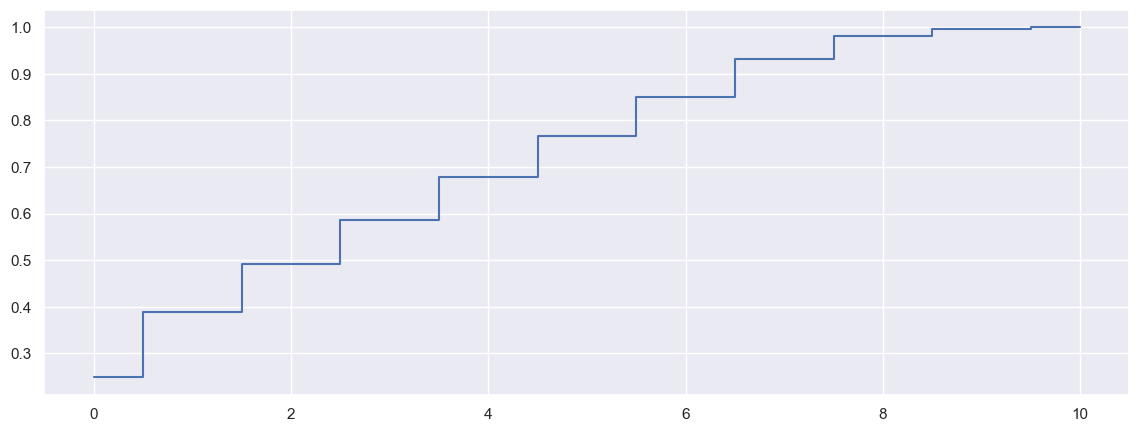

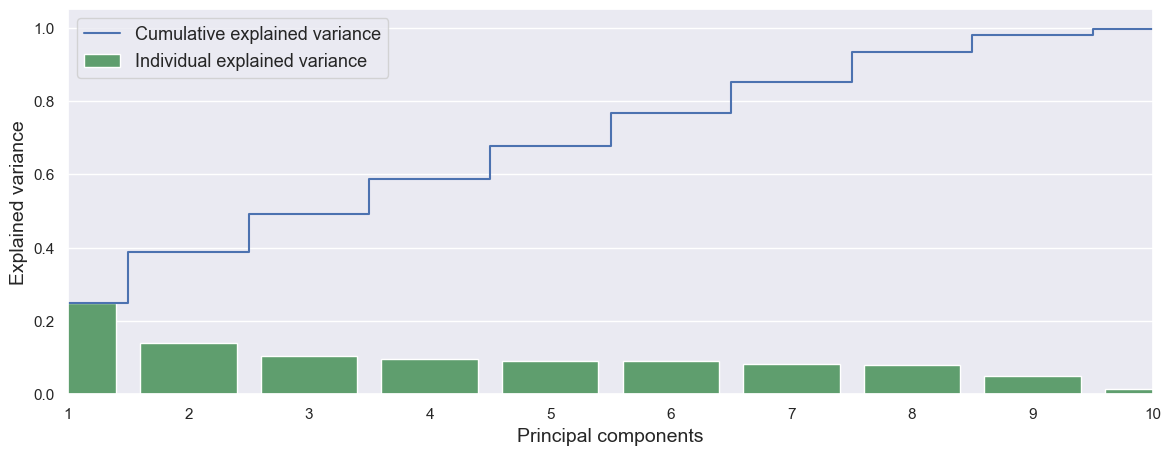

In [124]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)

plt.step(
    range(scaled_matrx.shape[1]),  # Ensure correct shape index
    pca.explained_variance_ratio_.cumsum(), 
    where='mid', 
    label='Cumulative explained variance'
)

# ✅ Correct `barplot()` usage
sns.barplot(
    x=np.arange(1, scaled_matrx.shape[1]+1),  # Corrected x-values
    y=pca.explained_variance_ratio_,         # y-values remain the same
    color='g',
    label='Individual explained variance',
    ax=ax  # Specify the axis
)

plt.xlim(0, 9)
plt.xlabel('Principal components', fontsize=14)
plt.ylabel('Explained variance', fontsize=14)
plt.legend(loc='upper left', fontsize=13)

plt.show()

Clustering Customers with KMeans


In [125]:
for n_cluster in range(4,15):
    KM = KMeans(n_clusters= n_cluster)
    clustersKM = KM.fit_predict(scaled_matrx)
    silh_score = silhouette_score(scaled_matrx, clustersKM)
    print("for {} clusters , Score = {}".format(n_cluster, silh_score))

for 4 clusters , Score = 0.2719945455195601
for 5 clusters , Score = 0.20598529857476017
for 6 clusters , Score = 0.2292207438396795
for 7 clusters , Score = 0.18893605115280243
for 8 clusters , Score = 0.2138770352818538
for 9 clusters , Score = 0.1948803273983489
for 10 clusters , Score = 0.2648996813090462
for 11 clusters , Score = 0.17547828178198507
for 12 clusters , Score = 0.23597625490611412
for 13 clusters , Score = 0.15826845846885937
for 14 clusters , Score = 0.16676399194537428


let's choose 11 as number of Customer clusters



In [126]:
n_cluster =11
silh_score = -1
while silh_score < 0.19:
    KM = KMeans(n_clusters= n_cluster)
    clustersKMcust = KM.fit_predict(scaled_matrx)
    silh_score = silhouette_score(scaled_matrx, clustersKMcust)
print("for {} clusters , Score = {}".format(n_cluster, silh_score))

for 11 clusters , Score = 0.23711228696748052


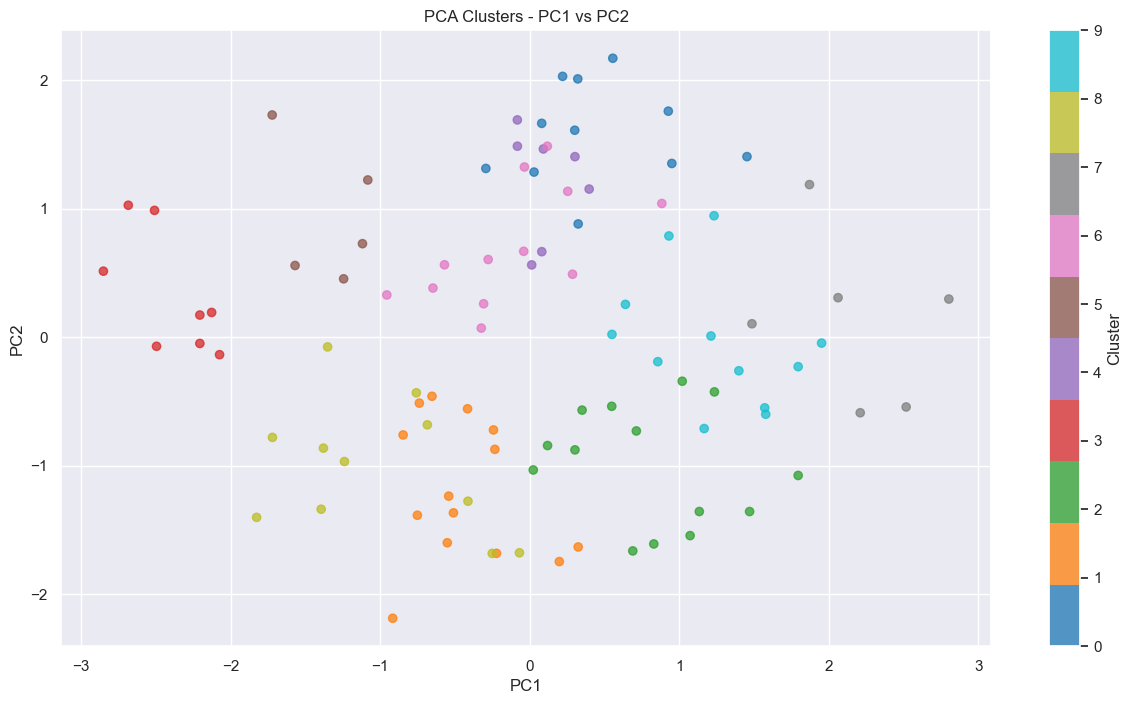

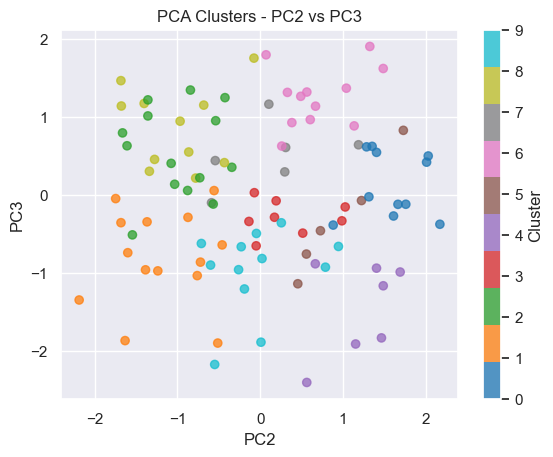

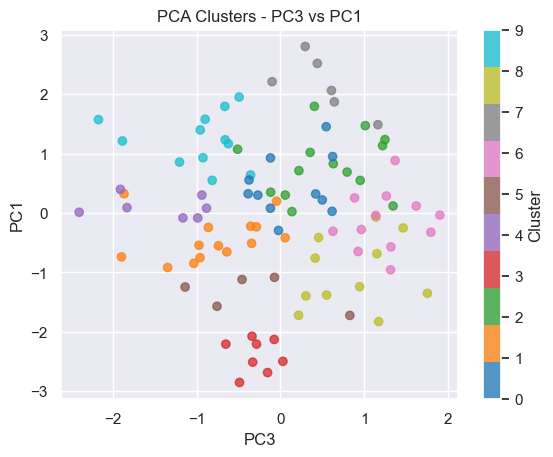

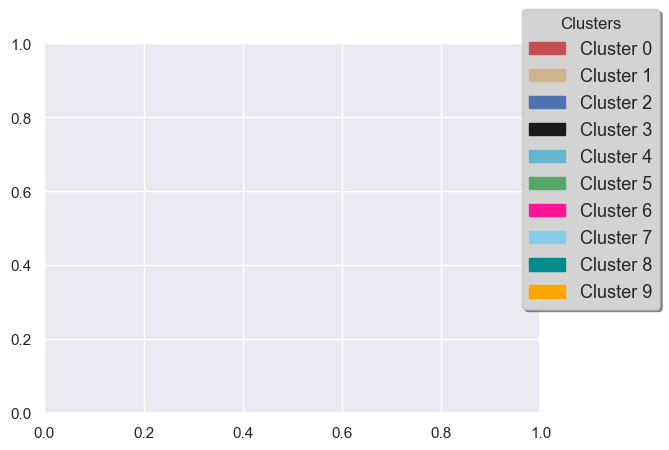

In [134]:
# Step 1: Generate Sample Data
np.random.seed(42)
data = np.random.rand(100, 5)  # 100 samples, 5 features
df = pd.DataFrame(data, columns=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5'])

# Step 2: Standardize the Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Step 3: Apply PCA
pca = PCA(n_components=3)  # Reduce to 3 Principal Components
dfpc = pca.fit_transform(scaled_data)

# Step 4: Perform KMeans Clustering
n_cluster = 10  # Change as needed
kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=10)
clusters = kmeans.fit_predict(dfpc)

# Step 5: Convert PCA Results to DataFrame
df_pca = pd.DataFrame(dfpc, columns=['PC1', 'PC2', 'PC3'])
df_pca['Cluster'] = clusters

# Step 6: Define function to plot PCA components
def make_pca_plot(data, pc_x, pc_y, cluster_col, w=2, h=5):
    plt.scatter(data[:, pc_x-1], data[:, pc_y-1], c=cluster_col, cmap='tab10', alpha=0.75)
    plt.xlabel(f'PC{pc_x}')
    plt.ylabel(f'PC{pc_y}')
    plt.title(f'PCA Clusters - PC{pc_x} vs PC{pc_y}')
    plt.colorbar(label='Cluster')
    plt.show()

# Step 7: Plot all PCA combinations
fig = plt.figure(figsize=(15, 8))
colors = ['r', 'tan', 'b', 'k', 'c', 'g', 'deeppink', 'skyblue', 'darkcyan', 'orange', 
          'yellow', 'tomato', 'seagreen']

for j in range(3):  # Limiting to first 3 PCs for visualization
    make_pca_plot(dfpc, j+1, (j+1) % 3 + 1, clusters, w=2, h=5)

# Step 8: Create Color Mapping for Legend
LABEL_COLOR_MAP2 = {i: colors[i] for i in range(n_cluster)}

comp_handler = [mpatches.Patch(color=LABEL_COLOR_MAP2[i], label=f'Cluster {i}') for i in range(n_cluster)]

# Step 9: Plot Legend
plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97),
           title='Clusters', facecolor='lightgrey',
           shadow=True, frameon=True, framealpha=1,
           fontsize=13, bbox_transform=plt.gcf().transFigure)

plt.show()

In [135]:
pd.DataFrame(pd.Series(clustersKMcust).value_counts()).T

2    3    10   8    6    0    7    1   9   5   4 
count  2016  363  274  243  227  179  114  106  61  20   5

Unique clusters: [ 2 10  1  0  6  4  3  8  7  9  5]


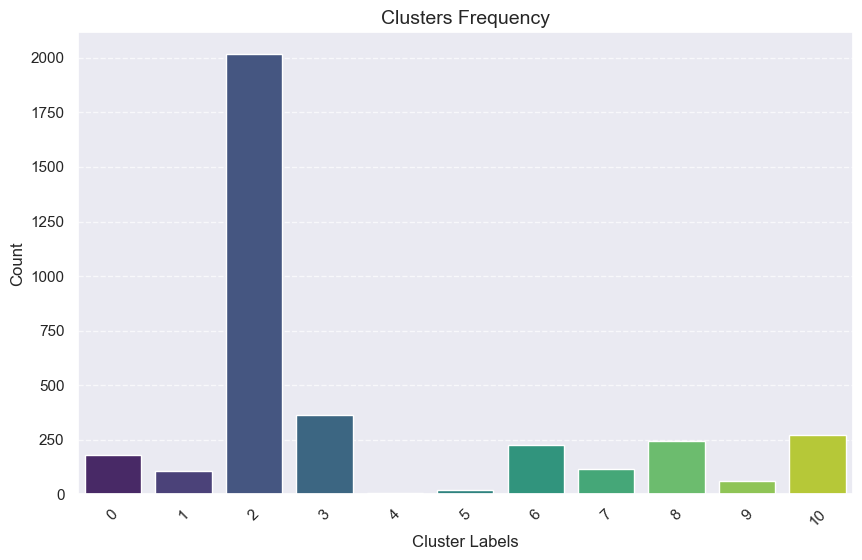

In [137]:
# Ensure clustersKMcust is a valid Pandas Series
clustersKMcust = pd.Series(clustersKMcust)

# Check the unique values
print("Unique clusters:", clustersKMcust.unique())

# Plot
plt.figure(figsize=(10, 6))  # Reduce figure size for better visibility
sns.countplot(x=clustersKMcust, palette="viridis")  # Ensure x-axis is categorical
plt.title("Clusters Frequency", fontsize=14)
plt.xlabel("Cluster Labels", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)  # Rotate labels if necessary
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [138]:
df_Cust['cluster']= clustersKMcust
df_Cust.head()

CustomerID  count      sum        mean     min     max  category_0  \
0      12347      5  2790.86  558.172000  382.52  711.79    7.051590   
1      12348      4  1797.24  449.310000  227.44  892.80    0.000000   
2      12350      1   334.40  334.400000  334.40  334.40    5.921053   
3      12352      6  2073.98  345.663333  144.35  840.30    5.207379   
4      12353      1    89.00   89.000000   89.00   89.00    0.000000   

   category_1  category_2  category_3  category_4  category_5  cluster  
0    0.634213    6.435292    2.343364    0.945945   10.566635        2  
1   20.030714    9.280897    2.323563    3.538759    0.000000       10  
2   11.961722    4.485646    0.000000    0.000000    0.000000       10  
3    9.643295    0.954686    6.509224    3.915178    1.764723        2  
4    0.000000    0.000000    0.000000    0.000000    0.000000        2

Cluster's morphology


Final dataframe will contain information of each cluster:

*number of customers it contains size feature

*how much spent in each catogeory

*min / max / Avg spent

We grab each cluster and take average of its information, then append it to the Final dataframe



In [142]:
# Assuming df_Cust is your DataFrame
df_final = df_Cust.groupby(by='cluster').mean().reset_index()

# Add 'size' column to count customers in each cluster
df_final['size'] = df_Cust.groupby('cluster')['CustomerID'].count().values

# Display final DataFrame
print(df_final)

    cluster    CustomerID      count            sum         mean          min  \
0         0  15170.988827   2.491620     695.141341   268.507048   208.169218   
1         1  14416.113208   1.547170    3034.716613  1796.069907  1547.117736   
2         2  15489.301091   2.423115     734.597978   303.722312   230.583870   
3         3  15345.738292  11.639118    5015.559008   469.566045   115.302948   
4         4  15672.400000  26.800000  133713.860000  6788.181470   700.888000   
5         5  14959.350000  55.200000   41379.489500  1074.056250    40.792000   
6         6  15190.925110   2.352423     625.300220   269.379638   224.211233   
7         7  15540.192982   2.149123     547.199474   240.324988   198.456754   
8         8  15402.395062   2.193416     706.752551   317.548253   259.971728   
9         9  14852.836066   2.196721     595.138361   266.687328   219.545738   
10       10  13985.383212   2.437956     940.777847   371.644343   275.400511   

             max  category_

In [143]:
df_final

cluster    CustomerID      count            sum         mean          min  \
0         0  15170.988827   2.491620     695.141341   268.507048   208.169218   
1         1  14416.113208   1.547170    3034.716613  1796.069907  1547.117736   
2         2  15489.301091   2.423115     734.597978   303.722312   230.583870   
3         3  15345.738292  11.639118    5015.559008   469.566045   115.302948   
4         4  15672.400000  26.800000  133713.860000  6788.181470   700.888000   
5         5  14959.350000  55.200000   41379.489500  1074.056250    40.792000   
6         6  15190.925110   2.352423     625.300220   269.379638   224.211233   
7         7  15540.192982   2.149123     547.199474   240.324988   198.456754   
8         8  15402.395062   2.193416     706.752551   317.548253   259.971728   
9         9  14852.836066   2.196721     595.138361   266.687328   219.545738   
10       10  13985.383212   2.437956     940.777847   371.644343   275.400511   

             max  category_0  category_1  category_2  category_3  category_4  \
0     338.141732    3.808620    2.251417   25.004564    6.854147    1.149643   
1    2067.459538    4.477260    2.658593    6.652556    5.145196    1.987415   
2     386.449202    3.159584    1.712328    3.479623    4.630655    1.111363   
3    1048.357824    5.588658    3.579427    6.777317    7.863724    2.233187   
4   22141.498000    5.803311    0.996659   10.438497   10.298502    3.290273   
5    5392.825500    5.433923    3.411741    6.041516    7.051161    2.304460   
6     323.036916    4.282918    2.658323    5.763142    8.873545   11.756251   
7     287.788246    2.455146    1.674035    3.331867    5.387402    0.765042   
8     378.210576   20.342132    2.008983    5.539925    6.451063    1.338833   
9     322.658361    0.833664    2.624574    4.413526   59.400316    1.072603   
10    479.594051    4.550997   18.853493    4.941643    5.251039    1.035264   

    category_5  size  
0     4.885850   179  
1     4.457046   106  
2     4.367149  2016  
3     6.445817   363  
4     9.904020     5  
5     7.542219    20  
6     5.193340   227  
7    34.896959   114  
8     5.259545   243  
9     1.492775    61  
10    4.924608   274

Radar Chart





Chart indicates how customer clusters are more likely to buy from such product clusters 

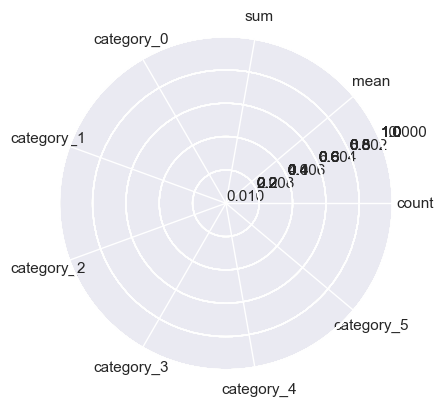

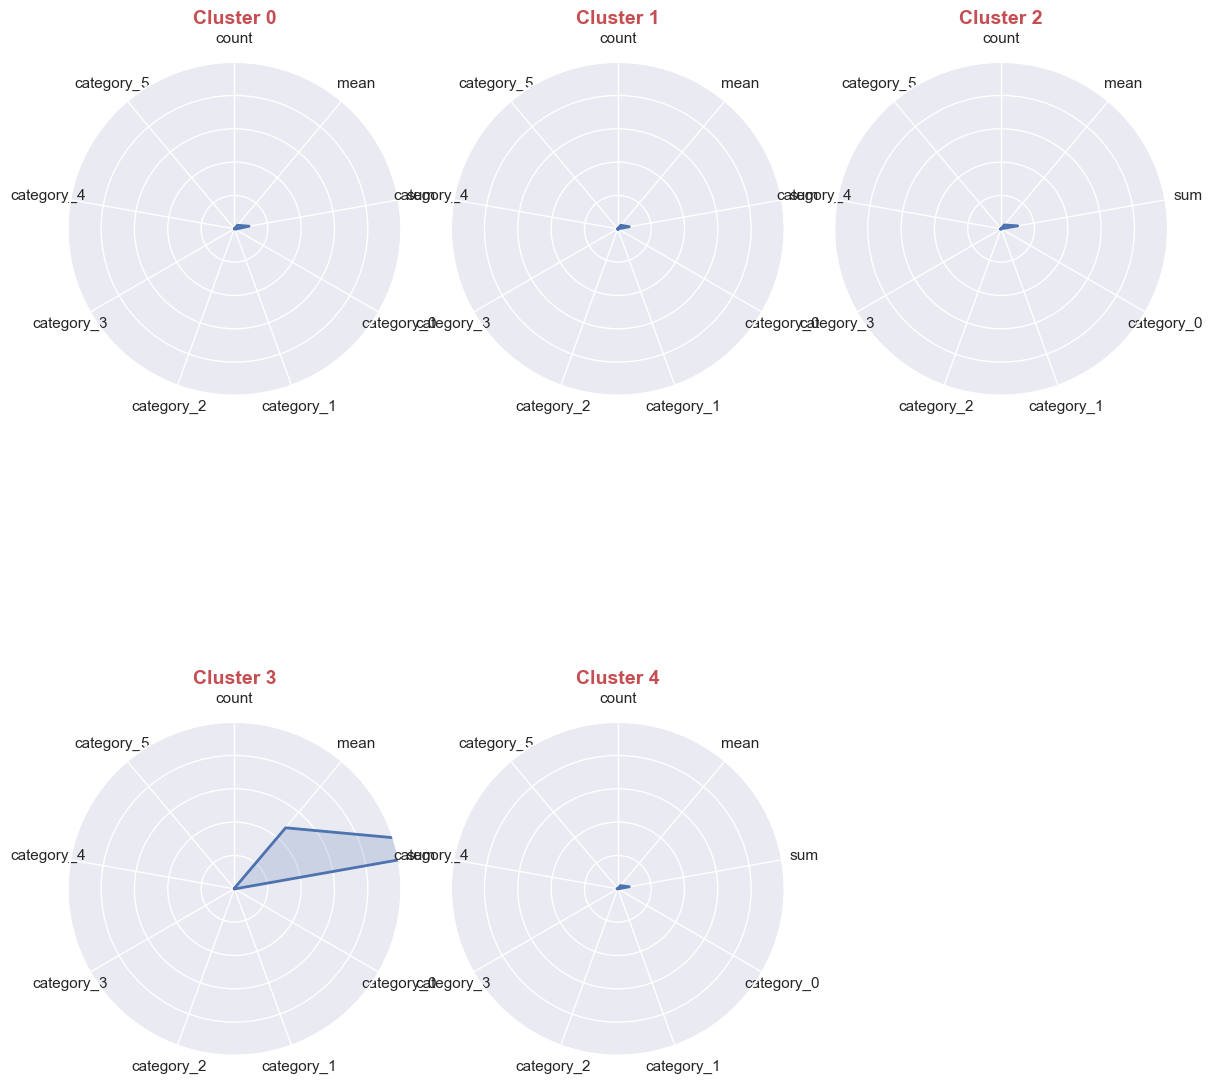

In [146]:
# Define a Radar Chart Class
class RadarChart():
    def __init__(self, fig, location, sizes, attributes, ranges):
        self.fig = fig
        self.location = location
        self.sizes = sizes
        self.attributes = attributes
        self.ranges = ranges
        self.num_vars = len(attributes)

        # Compute angles for radar chart
        self.angles = np.linspace(0, 2 * np.pi, self.num_vars, endpoint=False).tolist()
        self.angles += self.angles[:1]

        # Create subplot
        self.ax = fig.add_axes([location[0], location[1], sizes[0], sizes[1]], polar=True)
        self.ax.set_theta_offset(np.pi / 2)
        self.ax.set_theta_direction(-1)

        # Set labels and range
        self.ax.set_xticks(self.angles[:-1])
        self.ax.set_xticklabels(attributes)
        self.ax.set_yticklabels([])
        self.ax.set_ylim([min(min(r) for r in ranges), max(max(r) for r in ranges)])

    def plot(self, values, color='b', linewidth=2.0):
        values = np.concatenate((values, [values[0]]))  # Close the radar chart
        self.ax.plot(self.angles, values, color=color, linewidth=linewidth)

    def fill(self, values, alpha=0.2, color='b'):
        values = np.concatenate((values, [values[0]]))  # Close the radar chart
        self.ax.fill(self.angles, values, color=color, alpha=alpha)

    def title(self, title, color='r'):
        self.ax.set_title(title, color=color, size=14, fontweight='bold')

# Sample Data (Replace df_final with your actual dataframe)
df_final = pd.DataFrame({
    'cluster': [0, 1, 2, 3, 4],
    'count': [2.64, 2.42, 2.91, 35.0, 2.61],
    'sum': [888.5, 698.99, 1008.3, 14909.4, 701.13],
    'mean': [277.29, 278.72, 299.26, 4776.33, 249.94],
    'category_0': [53.15, 6.81, 6.14, 16.41, 11.76],
    'category_1': [11.61, 55.52, 15.71, 20.82, 11.68],
    'category_2': [4.94, 13.54, 7.74, 8.29, 5.24],
    'category_3': [11.46, 13.63, 58.33, 20.27, 11.80],
    'category_4': [13.07, 5.86, 7.83, 21.84, 51.81],
    'category_5': [5.75, 4.62, 4.22, 12.34, 7.69]
})

n_cluster = df_final.shape[0]  # Number of clusters
attributes = ['count', 'mean', 'sum', 'category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]

fig = plt.figure(figsize=(10, 12))

n_groups = n_cluster
i_cols = 3
i_rows = (n_groups // i_cols) + 1
size_x, size_y = (1 / i_cols), (1 / i_rows)

for ind in range(n_cluster):
    ix = ind % 3
    iy = i_rows - ind // 3
    pos_x = ix * (size_x + 0.05)
    pos_y = iy * (size_y + 0.05)
    location = [pos_x, pos_y]
    sizes = [size_x, size_y]

    data = df_final.loc[ind, attributes].values
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color='b', linewidth=2.0)
    radar.fill(data, alpha=0.2, color='b')
    radar.title(title=f'Cluster {ind}', color='r')

plt.show()

Classification


classifying is for predicting what customer would buy on his next visit


We try various models to get the best classification accuracy for our customers

Clasification class is for the ease of the common methods of models we try

In [147]:
class Classification(object):
    ''' for Various classifiers uses '''
    def __init__(self, clfr, params=None):
        if params:
            self.clfr = clfr(**params)
        else:
            self.clfr = clfr()
    
    def train(self, x_train, y_train):
        self.clfr.fit(x_train, y_train)
    
    def predict(self, x):
        self.clfr.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(self.clfr,parameters, cv=Kfold)
    
    def grid_fit(self, X, Y):
        self.grid.fit(X,Y)
    
    def grid_predict(self, X, Y):
        self.yhat = self.grid.predict(X)
        print("Accuracy : {:.2f}".format(metrics.accuracy_score(Y, self.yhat)*100))

Determine the input X matrix, and y vector Output

In [148]:
Xcols = [col for col in df_selected.columns if 'categ' in col]

X = df_Cust[Xcols]
Y = df_Cust['cluster']




splitting the data to train and validation datasets

In [149]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.8)

SVC


slow

In [150]:
svc = Classification(clfr= svm.LinearSVC)
svc.grid_search(parameters=[{'C':np.logspace(-2,2,10)}], Kfold = 5)
# best C=0.0278
svc.grid_fit(X= X_train, Y=y_train)
svc.grid_predict(X=X_test, Y=y_test)

Accuracy : 82.27


Logistic Regression


fast

In [151]:
lr = Classification(clfr= linear_model.LogisticRegression)
lr.grid_search(parameters=[{'C':np.logspace(-2,2,10)}], Kfold = 5)
## best C=0.0278
lr.grid_fit(X= X_train, Y=y_train)
lr.grid_predict(X=X_test, Y=y_test)

Accuracy : 83.10


K-NN


fast

In [152]:
dtr = Classification(clfr= tree.DecisionTreeClassifier)
dtr.grid_search(parameters=[{'criterion':['entropy', 'gini'], 'max_features':['sqrt', 'log2'] }], Kfold = 5)
## best 'gini', 'sqrt'
dtr.grid_fit(X= X_train, Y=y_train)
dtr.grid_predict(X=X_test, Y=y_test)

Accuracy : 74.79


Decision Tree


fast



In [153]:
dtr = Classification(clfr= tree.DecisionTreeClassifier)
dtr.grid_search(parameters=[{'criterion':['entropy', 'gini'], 'max_features':['sqrt', 'log2'] }], Kfold = 5)
## best 'gini', 'sqrt'
dtr.grid_fit(X= X_train, Y=y_train)
dtr.grid_predict(X=X_test, Y=y_test)

Accuracy : 75.48


Random Forest


slow

In [154]:
rf = Classification(clfr= ensemble.RandomForestClassifier)
params = [{'criterion':['entropy','gini'], 'n_estimators': [20, 40, 60, 80, 100], 'max_features':['sqrt','log2']}]
## best 'gini', 20 , sqrt
rf.grid_search(parameters=params, Kfold = 5)
rf.grid_fit(X= X_train, Y=y_train)
rf.grid_predict(X=X_test, Y=y_test)

Accuracy : 84.07


Ada Boost


medium

In [155]:
ada = Classification(clfr= AdaBoostClassifier)
params = [{'n_estimators': [x for x in np.arange(10,100,10)]}]  ## best 50
ada.grid_search(parameters=params, Kfold = 5)
ada.grid_fit(X= X_train, Y=y_train)
ada.grid_predict(X=X_test, Y=y_test)

Accuracy : 66.48


Gradient Boosting


slow

In [156]:
gbo = Classification(clfr= ensemble.GradientBoostingClassifier)
params = [{'n_estimators': [x for x in np.arange(10,100,10)]}] ## best 20
gbo.grid_search(parameters=params, Kfold = 5)
gbo.grid_fit(X= X_train, Y=y_train)
gbo.grid_predict(X=X_test, Y=y_test)

Accuracy : 82.55


Voting


using the VotingClassifier Object

In [167]:
# Define parameter grids
svc_grid = {'C': [0.1, 1, 10]}
lr_grid = {'C': [0.1, 1, 10]}
knn_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
dtr_grid = {'max_depth': [3, 5, 10]}
rf_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10]}
ada_grid = {'n_estimators': [50, 100]}
gbo_grid = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}

In [168]:
svc = GridSearchCV(svm.LinearSVC(), svc_grid, cv=5).fit(X_train, y_train)
lr = GridSearchCV(linear_model.LogisticRegression(), lr_grid, cv=5).fit(X_train, y_train)
knn = GridSearchCV(neighbors.KNeighborsClassifier(), knn_grid, cv=5).fit(X_train, y_train)
dtr = GridSearchCV(tree.DecisionTreeClassifier(), dtr_grid, cv=5).fit(X_train, y_train)
rf = GridSearchCV(ensemble.RandomForestClassifier(), rf_grid, cv=5).fit(X_train, y_train)
ada = GridSearchCV(AdaBoostClassifier(), ada_grid, cv=5).fit(X_train, y_train)
gbo = GridSearchCV(ensemble.GradientBoostingClassifier(), gbo_grid, cv=5).fit(X_train, y_train)

In [169]:
# Get best models
svc_best = svm.LinearSVC(**svc.best_params_)
lr_best = linear_model.LogisticRegression(**lr.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.best_params_)
dtr_best = tree.DecisionTreeClassifier(**dtr.best_params_)
rf_best = ensemble.RandomForestClassifier(**rf.best_params_)
ada_best = AdaBoostClassifier(**ada.best_params_)
gbo_best = ensemble.GradientBoostingClassifier(**gbo.best_params_)

In [171]:
from sklearn.ensemble import VotingClassifier

In [175]:
votingClsf = VotingClassifier(
    estimators=[
        ('svc', svc_best),
        ('lr', lr_best),
        ('knn', knn_best),
        ('dtr', dtr_best),
        ('gbo', gbo_best)
    ], 
)

In [176]:
votingClsf= votingClsf.fit(X_train, y_train)

In [177]:
yhat = votingClsf.predict(X_test)
print("Accuracy : {:.2f}".format(metrics.accuracy_score(y_test, yhat) *100))

Accuracy : 84.76


Testing Predictions



on the 2 months test_set
Formating data with same processes of the training_set done

In [178]:
## Grouping for each user the same Features
df_c = test_set.copy(deep = True)

df_Cust = df_c.groupby(by='CustomerID')['basketPrice'].agg(['count','sum','mean','min','max'])

for i in range(6):
    col = 'category_{}'.format(i)
    df_Cust.loc[:, col] = df_c.groupby(by='CustomerID')[col].sum() / df_Cust['sum'] * 100

df_Cust.reset_index(inplace=True, drop=False)

In [180]:
scaler = StandardScaler()  # Re-initialize
scaled_matrx_test = scaler.fit_transform(matrx_test)  # Fit & transform on same features

In [181]:
features = [col for col in df_Cust.columns if col != "CustomerID"]
matrx_test = df_Cust[features].values
scaled_matrx_test = scaler.transform(matrx_test)

In [182]:
y = KM.predict(scaled_matrx_test)

In [183]:
y.shape

(2551,)

In [184]:
Xcols = [col for col in df_selected.columns if 'categ' in col]
X = df_Cust[Xcols]

In [185]:
X.shape

(2551, 6)

In [196]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [198]:
# Loop through classifiers and evaluate them
for clf, label in zip(clsfrX, clsfrLabels):
    print(30 * "-", "\n{}".format(label))  # Print classifier name
    clf.fit(X_train, y_train)  # Train the classifier
    y_pred = clf.predict(X_test)  # Make predictions
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

------------------------------ 
support Vecotor Machine
Accuracy: 0.8240997229916898
------------------------------ 
Logostic Regression
Accuracy: 0.8379501385041551
------------------------------ 
k-Nearest Neighbors
Accuracy: 0.8074792243767313
------------------------------ 
Decision Tree
Accuracy: 0.8254847645429363
------------------------------ 
Random Forest
Accuracy: 0.8421052631578947
------------------------------ 
Gradient Boosting
Accuracy: 0.6648199445983379


In [200]:
predictions = votingClsf.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(y, predictions)))

Precision: 82.52 % 
